**Preprocessing the Data**

In [1]:
# Loading in all necessary libraries.

library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)
options(repr.matrix.max.rows = 10)

# Setting the seed.
set.seed(14)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# Loading in Cleveland data set

URL <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

cleveland_data <- read_csv(URL, col_names=FALSE, show_col_types = FALSE)

# Since column names aren't pre-specified, we rename them using colnames, according to the UCI repository.

colnames(cleveland_data) <- c("age", "sex", "cp", "trestbps", 
                              "chol", "fbs", "restecg", "thalach", 
                              "exang", "oldpeak", "slope", "ca", "thal", "num")

cleveland_data <- cleveland_data |>
    mutate(ca = as.numeric(ca), thal = as.numeric(thal)) |>
    filter(ca != "NA", thal != "NA")

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [3]:
# Adding column indicating yes or no for presence of heart disease

cl_have_disease <- cleveland_data |>
    filter(num == 1 | num == 2 | num == 3 | num == 4) |>
    mutate(hd = "yes") |>
    mutate(hd = as_factor(hd))
cl_no_disease <- cleveland_data |>
    filter(num == 0) |>
    mutate(hd = "no") |>
    mutate(hd = as_factor(hd))
cl_data_alt <- rbind(cl_have_disease, cl_no_disease)

In [4]:
# Loading in Hungarian data set

URL2 <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data"

hungarian_data <- read_delim(URL2, col_names = FALSE, delim = " ", show_col_types = FALSE)

colnames(hungarian_data) <- c("age", "sex", "cp", "trestbps", 
                              "chol", "fbs", "restecg", "thalach", 
                              "exang", "oldpeak", "slope", "ca", "thal", "num")


# Combine levels 1,2,3,4 into hd column. Levels 1-4 as "yes", level 0 as "no."

hung_have_disease <- hungarian_data |>
    filter(num == 1 | num == 2 | num == 3 | num == 4) |>
    mutate(hd = "yes") |>
    mutate(hd = as_factor(hd))

hung_no_disease <- hungarian_data |>
    filter(num == 0) |>
    mutate(hd = "no") |>
    mutate(hd = as_factor(hd))

hung_data_alt <- rbind(hung_have_disease, hung_no_disease)

In [5]:
heart_data <- rbind(hung_data_alt, cl_data_alt)
heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,hd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
49,0,3,160,180,0,0,156,0,1.0,2,-9,-9,1,yes
48,0,4,138,214,0,0,108,1,1.5,2,-9,-9,3,yes
37,1,4,140,207,0,0,130,1,1.5,2,-9,-9,1,yes
58,1,2,136,164,0,1,99,1,2.0,2,-9,-9,3,yes
49,1,4,140,234,0,0,140,1,1.0,2,-9,-9,3,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,1,2,122,192,0,0,174,0,0.0,1,0,3,0,no
56,1,2,130,221,0,2,163,0,0.0,1,0,7,0,no
56,1,2,120,240,0,0,169,0,0.0,3,0,3,0,no


In [6]:
# Percentages of hd (yes, no) 

num_obs_h <- nrow(heart_data)
heart_proportions <- heart_data |>
    group_by(hd) |>
    summarize(
        count = n(),
        percentage = n() / num_obs_h * 100
        )
heart_proportions

hd,count,percentage
<fct>,<int>,<dbl>
yes,243,41.11675
no,348,58.88325


In [8]:
# Creating Training and Testing Data Sets

heart_split <- initial_split(heart_data, prop = 0.75, strata = hd)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

**Finding the Best Predictors using Forward Selection From Textbook**

Warning: Code takes 8-9 min. to run

In [9]:
# Created a duplicate set to perform Forward Selection
# Standardized this new subset

heart_subset <- heart_training |> select(-num)

# Implementing Forward Selection Code to find best predictors
names <- colnames(heart_subset |> select(-hd))

# Create a tibble to store accuracies
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# Create a model spec
knn_FS_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create a 5-fold cross-validation object
heart_vfold <- vfold_cv(heart_subset, v = 5, strata = hd)

# Store the total number of predictors
n_total <- length(names)

# Stores selected predictors
selected <- c()
for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("hd", "~", paste(preds_new, collapse="+"))
        heart_FS_recipe <- recipe(as.formula(model_string),
                                data = heart_subset) |>
                            step_scale(all_predictors()) |>
                            step_center(all_predictors())
        acc <- workflow() |>
            add_recipe(heart_FS_recipe) |>
            add_model(knn_FS_spec) |>
            tune_grid(resamples = heart_vfold, grid = 10) |>
            collect_metrics() |>
            filter(.metric == "accuracy") |>
            summarize(mx = max(mean))
        acc <- acc$mx |> unlist()
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |>
        add_row(size = i,
                model_string = models[[jstar]],
                accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,hd ~ oldpeak,0.7020531
2,hd ~ oldpeak+cp,0.8011667
3,hd ~ oldpeak+cp+restecg,0.8238174
4,hd ~ oldpeak+cp+restecg+fbs,0.8193735
5,hd ~ oldpeak+cp+restecg+fbs+sex,0.8194252
⋮,⋮,⋮
9,hd ~ oldpeak+cp+restecg+fbs+sex+trestbps+ca+thal+age,0.8128606
10,hd ~ oldpeak+cp+restecg+fbs+sex+trestbps+ca+thal+age+exang,0.8060158
11,hd ~ oldpeak+cp+restecg+fbs+sex+trestbps+ca+thal+age+exang+slope,0.8172018


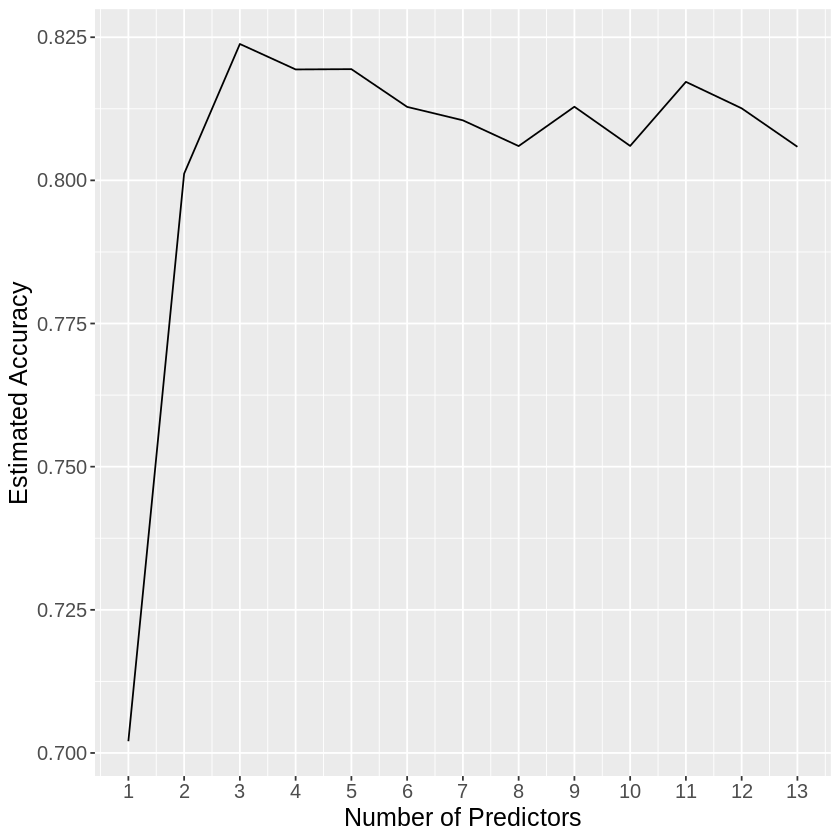

In [10]:
best_preds_plot <- ggplot(accuracies, aes(x = size, y = accuracy)) +
    geom_line() +
    xlab("Number of Predictors") +
    ylab("Estimated Accuracy") +
    scale_x_continuous(breaks = 1:13) +
    theme(text = element_text(size = 15))

best_preds_plot

In [11]:
best_preds <- accuracies |> slice(4,7)
best_preds

size,model_string,accuracy
<int>,<chr>,<dbl>
4,hd ~ oldpeak+cp+restecg+fbs,0.8193735
7,hd ~ oldpeak+cp+restecg+fbs+sex+trestbps+ca,0.8104858


Using 4 and 7 predictors produce a similar accuracy, with 4 being slightly better. Thus, the best predictors are "oldpeak", "cp", "thal", and "slope".

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7470993,10,0.01724606,Preprocessor1_Model01
1,roc_auc,binary,0.7180874,10,0.01905491,Preprocessor1_Model01
2,accuracy,binary,0.7380083,10,0.01747400,Preprocessor1_Model02
2,roc_auc,binary,0.7816783,10,0.01738646,Preprocessor1_Model02
3,accuracy,binary,0.7764471,10,0.01488295,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,roc_auc,binary,0.8697106,10,0.02017927,Preprocessor1_Model48
49,accuracy,binary,0.7922069,10,0.02082671,Preprocessor1_Model49
49,roc_auc,binary,0.8698343,10,0.02081452,Preprocessor1_Model49


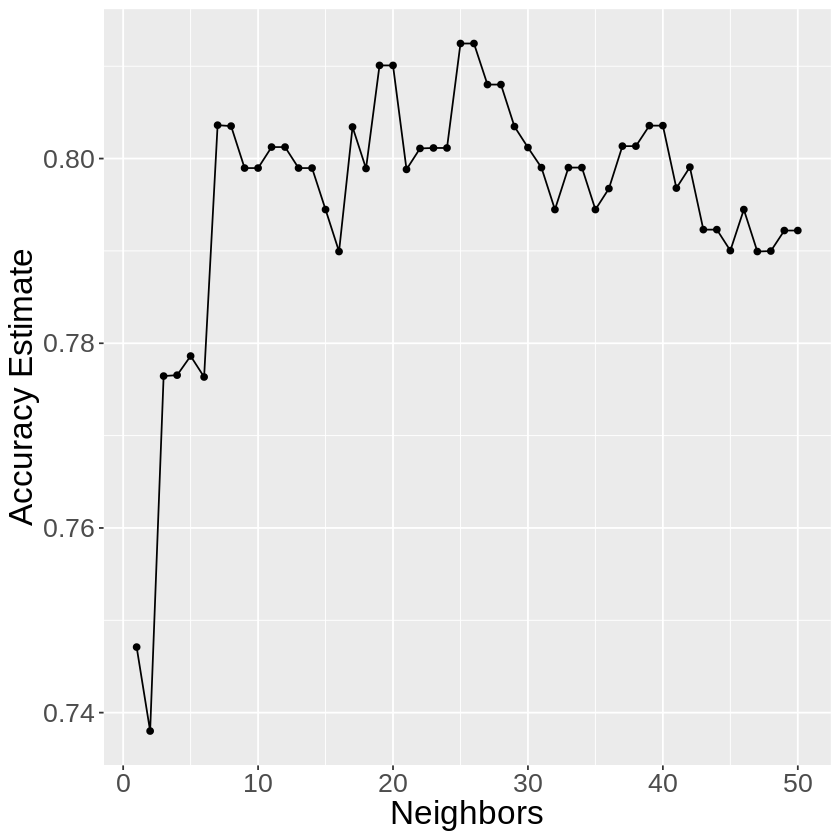

In [12]:
# Creating a 10-fold cross-validation object
heart_vfold <- vfold_cv(heart_training, v = 10, strata = hd)

# Preparing the recipe according to the best predictors as found above
heart_recipe <- recipe(hd ~ oldpeak + cp + thal + slope, data = heart_training) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())

# K-nn Classification spec
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
              set_engine("kknn") |>
              set_mode("classification")

# Setting possible values of best K to be in between 1 and 50
gridvals <- tibble(neighbors = seq(1, 50))

# Combining everything into a workflow and collecting the metrics to identify the best value of K
knn_results <- workflow() |>
                  add_recipe(heart_recipe) |>
                  add_model(knn_spec) |>
                  tune_grid(resamples = heart_vfold, grid = gridvals) |>
                  collect_metrics()

knn_results

accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Creating a cross-validation plot to visualise accuracies for the different values of K
cross_val_plot <- accuracies |> 
                    ggplot(aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy Estimate") +
                    theme(text = element_text(size = 20))

cross_val_plot

In [13]:
# Choosing the best value of K
conclusions <- knn_results |>
                filter(.metric == "accuracy") |>
                select(neighbors, mean, std_err) |>
                arrange(mean) |>
                tail(1)

conclusions

neighbors,mean,std_err
<int>,<dbl>,<dbl>
26,0.8124594,0.01810257


**From the above conclusions, we can see that the best value for K to be used is 24.**

In [14]:
#Retraining the classifer 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 24) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    fit(data = heart_training)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(24,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1896163
Best kernel: rectangular
Best k: 24

In [16]:
#Predicting the labels in the test set
heart_test_predictions <- predict(knn_fit, heart_testing) |>
    bind_cols(heart_testing)
heart_test_predictions 

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,hd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
yes,49,0,3,160,180,0,0,156,0,1,2,-9,-9,1,yes
no,58,1,2,136,164,0,1,99,1,2,2,-9,-9,3,yes
yes,60,1,4,100,248,0,0,125,0,1,2,-9,-9,1,yes
yes,44,1,2,150,288,0,0,150,1,3,2,-9,-9,3,yes
no,53,1,3,145,518,0,0,130,0,0,-9,-9,-9,3,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
no,44,0,3,118,242,0,0,149,0,0.3,2,1,3,0,no
no,60,0,1,150,240,0,0,171,0,0.9,1,0,3,0,no
no,44,1,3,120,226,0,0,169,0,0.0,1,0,3,0,no


In [20]:
#Computing the accuracy
heart_accuracies <- heart_test_predictions |>
    metrics(truth = hd, estimate = .pred_class) |>
    filter(.metric =="accuracy")

In [21]:
#Looking at the confusion matrix
confusion <- heart_test_predictions |>
             conf_mat(truth = hd, estimate = .pred_class)
confusion 

          Truth
Prediction yes no
       yes  44 14
       no   17 73